# Step 0 - Understanding Req

## Mandatory Tasks

1. Calculate the total revenue generated from subscriptions for each country.
2. Calculate the total number of trials given to users who came from Instagram.
3. Create a new column named 'acquisition_channel' by categorizing users based on their 'attribution_source':
   - 'Paid': users from instagram or tiktok
   - 'Organic': users from organic sources
4. Analyze the trial-to-subscription conversion rate:
   - Calculate the overall conversion rate
   - Break down the conversion rate by attribution_source
5. Calculate the median subscription duration (in months) for each country
6. Calculate the Average Lifetime Value (LTV) by country

## Optional Tasks



7. Predict the churn probability for user #1002 (Clark Kent)
   - Use any relevant features from the dataset
   - Explain your model selection and feature engineering process
   - Provide confidence intervals if applicable

8. Predict the potential Lifetime Value (pLTV) for user #1001 (Bruce Wayne)
   - Explain your methodology and assumptions

## Evaluation Criteria(From older and much detailed commit)

1. **Code Quality**
   - Clean, well-documented code
   - Efficient SQL queries
   - Proper use of Python data structures and libraries

2. **Analysis Quality**
   - Depth of insights
   - Statistical rigor
   - Handling of edge cases

3. **Communication**
   - Clear explanation of methodology
   - Well-structured presentation of results
   - Visualization quality

# Step 1 - Importing libs

In [285]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.figure(figsize=(15, 10))
plt.style.use('seaborn') 
sns.set_palette('deep')

C:\Users\batuh\AppData\Local\Temp\ipykernel_6588\2347505175.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1500x1000 with 0 Axes>

# Step 2 - Connection to DB


In [286]:
conn = sqlite3.connect('papcorns.sqlite')

# Step 3 - Creating DataFrame from db

In [287]:
users_df = pd.read_sql_query("SELECT * FROM users;", conn)

In [288]:
events_df = pd.read_sql_query("SELECT * FROM user_events;", conn)

# Step 4 - Exploring dataFrames

### For users data

In [289]:
users_df.shape # Shape of df

(1002, 5)

In [290]:
users_df.info() # Info of df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1002 non-null   int64 
 1   created_at          1002 non-null   object
 2   attribution_source  1002 non-null   object
 3   country             1002 non-null   object
 4   name                1002 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.3+ KB


In [291]:
users_df['created_at'] = pd.to_datetime(users_df['created_at']) # Changing 'created_at' from object to datetime

In [292]:
list(users_df.columns) # Column names

['id', 'created_at', 'attribution_source', 'country', 'name']

In [293]:
users_df.head() # Top 5 user data

,id,created_at,attribution_source,country,name
0,1,2024-05-07,instagram,US,Eve Brown
1,2,2024-10-12,instagram,NL,Frank Moore
2,3,2024-10-15,tiktok,TR,Ivy Anderson
3,4,2024-08-28,tiktok,TR,Alice Brown
4,5,2024-04-03,organic,NL,Bob Moore


In [294]:
users_df.describe() # No meainingfull numeric value to work

,id
count,1002.000000
mean,501.500000
std,289.396786
min,1.000000
25%,251.250000
50%,501.500000
75%,751.750000
max,1002.000000


In [295]:
users_df.isna().sum() # No null row in columns

id                    0
created_at            0
attribution_source    0
country               0
name                  0
dtype: int64

In [296]:
users_df["attribution_source"].value_counts() # 3 Different values with nearly the same amount

tiktok       352
organic      344
instagram    306
Name: attribution_source, dtype: int64

Text(0, 0.5, 'User')

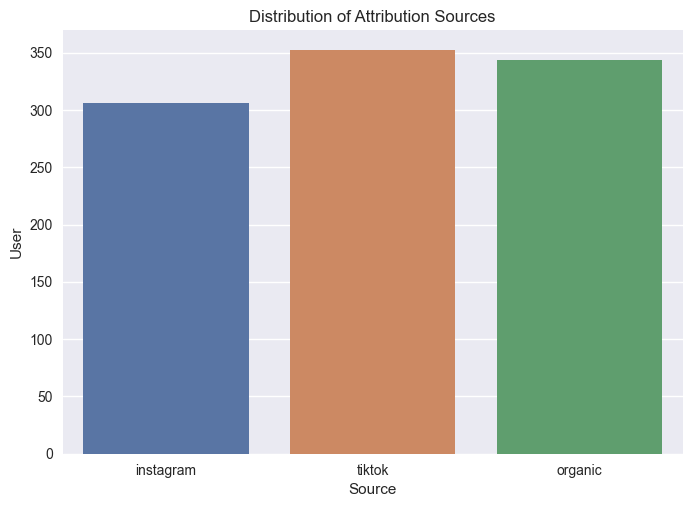

In [297]:
# Graph for user/source
sns.countplot(data=users_df, x='attribution_source')
plt.title('Distribution of Attribution Sources')
plt.xlabel('Source')
plt.ylabel('User')

In [298]:
users_df['country'].value_counts() # Again, 3 different values with nearly the same amount

TR    354
US    340
NL    308
Name: country, dtype: int64

Text(0, 0.5, 'User')

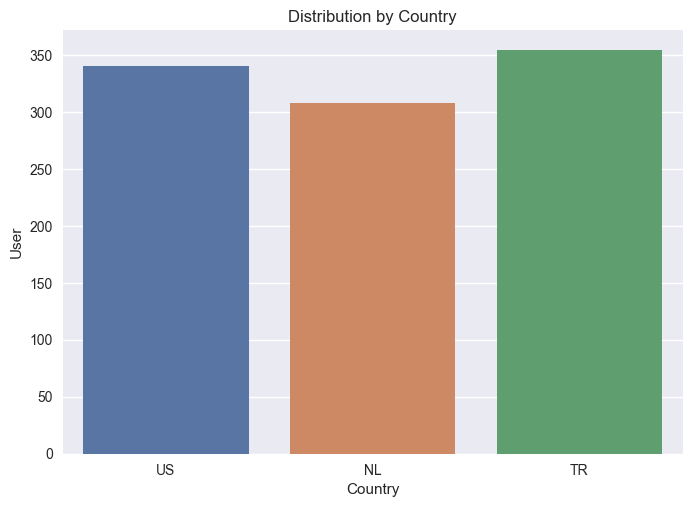

In [299]:
# Graph for user/country
sns.countplot(data=users_df, x='country')
plt.title('Distribution by Country')
plt.xlabel('Country')
plt.ylabel('User')

(array([0, 1, 2]), [Text(0, 0, 'NL'), Text(1, 0, 'TR'), Text(2, 0, 'US')])

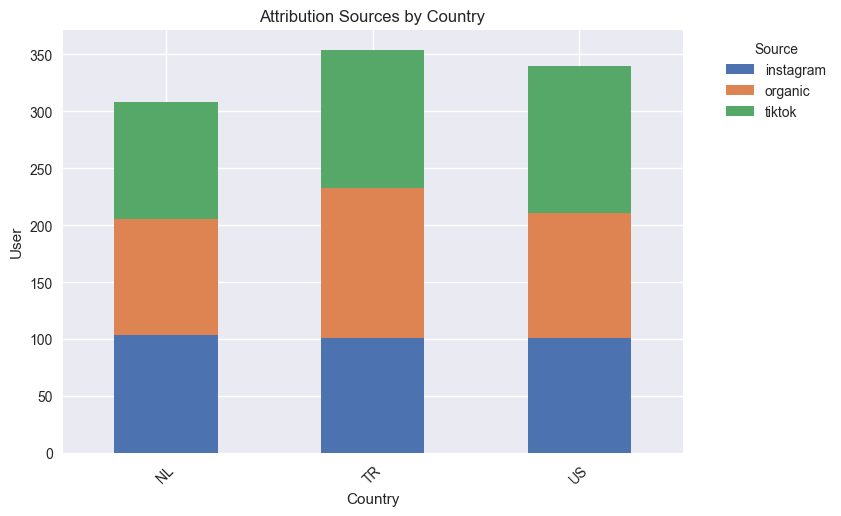

In [300]:
# Graph for user/country by source
attribution_by_country = pd.crosstab(users_df['country'], users_df['attribution_source'])
attribution_by_country.plot(kind='bar', stacked=True)
plt.title('Attribution Sources by Country')
plt.xlabel('Country')
plt.ylabel('User')
plt.legend(title='Source', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)

Text(0, 0.5, 'Number of Sign-ups')

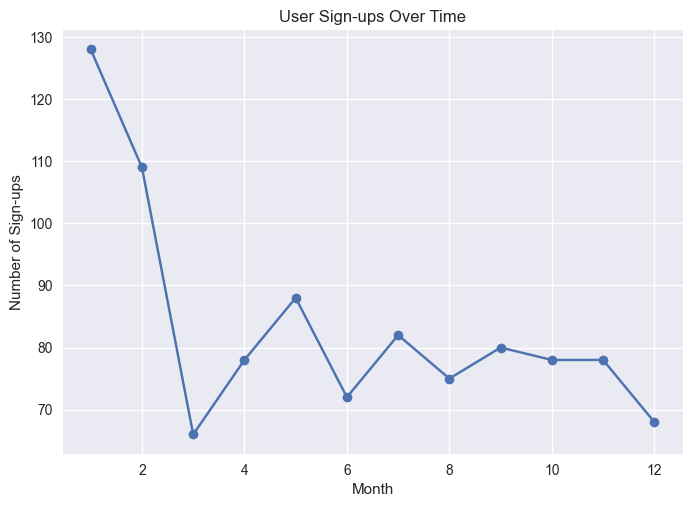

In [301]:
# Graph for user sign-up over time(month)
users_df.groupby(users_df['created_at'].dt.month)['id'].count().plot(kind='line', marker='o')
plt.title('User Sign-ups Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Sign-ups')

### For event data

In [302]:
events_df.shape # More rows than user's data

(3486, 5)

In [303]:
events_df.info() # Info of df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          3486 non-null   int64  
 1   created_at  3486 non-null   object 
 2   user_id     3486 non-null   int64  
 3   event_name  3486 non-null   object 
 4   amount_usd  1231 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 136.3+ KB


In [304]:
events_df['created_at'] = pd.to_datetime(events_df['created_at']) # Changing 'created_at' from object to datetime format.

In [305]:
list(events_df.columns) # Columns of df

['id', 'created_at', 'user_id', 'event_name', 'amount_usd']

In [306]:
events_df.head() # 'user_id' propably corrseponds to users_df 'id'.

,id,created_at,user_id,event_name,amount_usd
0,1,2024-05-07,1,app_install,NaN
1,2,2024-05-12,1,trial_started,NaN
2,3,2024-05-24,1,trial_cancelled,NaN
3,4,2024-10-12,2,app_install,NaN
4,5,2024-10-13,2,trial_started,NaN


In [307]:
# Checking if it was true.
events_df['user_id'].value_counts()

# Lenght is 1002 and in users_df our shape is (1002, 5) so we have every user with some event in events_df.

832     8
331     8
950     8
359     8
819     8
       ..
492     1
489     1
477     1
469     1
1002    1
Name: user_id, Length: 1002, dtype: int64

In [308]:
'''
We have a some numerical values, we can make some insights on 'amount_usd'.
Maybe I can find some relations to other categorical values .
'''

events_df.describe() 

,id,user_id,amount_usd
count,3486.000000,3486.000000,1231.000000
mean,1743.500000,502.910499,7.836466
std,1006.465846,289.650625,2.220009
min,1.000000,1.000000,4.990000
25%,872.250000,256.250000,4.990000
50%,1743.500000,499.500000,8.990000
75%,2614.750000,754.000000,9.990000
max,3486.000000,1002.000000,9.990000


In [309]:
events_df.dtypes

# We have two object types. One is time-stamp and the other one is event_name, it's time to check it.

id                     int64
created_at    datetime64[ns]
user_id                int64
event_name            object
amount_usd           float64
dtype: object

In [310]:
'''
There are 6 different events. They can be categorized when I preprocess our data. 
There may be some correlations between 'amount_usd' with events.
'''
events_df['event_name'].value_counts() 


app_install               1002
subscription_renewed       750
trial_started              682
subscription_started       481
subscription_cancelled     370
trial_cancelled            201
Name: event_name, dtype: int64

Text(0, 0.5, 'Event Type')

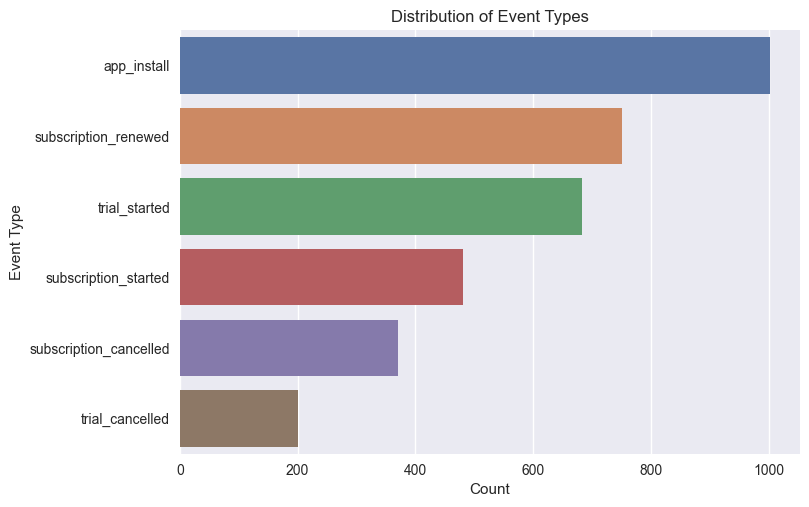

In [311]:
# Graph for event type/event count
event_counts = events_df['event_name'].value_counts()
sns.barplot(x=event_counts.values, y=event_counts.index) # It's horizontal because some titles are long and become unreadable verticaly
plt.title('Distribution of Event Types')
plt.xlabel('Count')
plt.ylabel('Event Type')

In [312]:
events_df.isna().sum()

# We have 2255 null values in 'amount_usd' column, it can be 0 for not spending any or can be a missing data. I will inspect it in a moment.

id               0
created_at       0
user_id          0
event_name       0
amount_usd    2255
dtype: int64

In [313]:
events_df[events_df['amount_usd'].notna()]['event_name'].value_counts()

# There are two 'event_name' that doesn't make the amount null.

subscription_renewed    750
subscription_started    481
Name: event_name, dtype: int64

Text(0, 0.5, 'Amount (USD)')

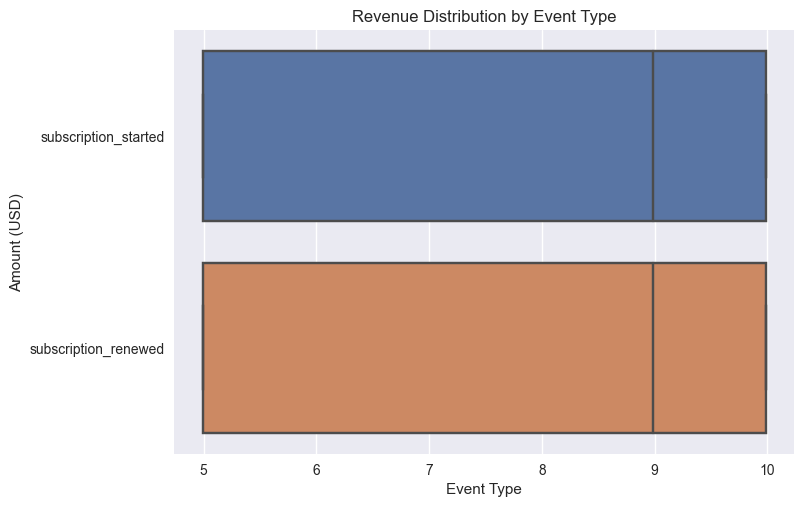

In [314]:
# Graph for revenue/event type
revenue_data = events_df[events_df['event_name'].isin(['subscription_renewed', 'subscription_started'])]
sns.boxplot(y='event_name', x='amount_usd', data=revenue_data)
plt.title('Revenue Distribution by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Amount (USD)')

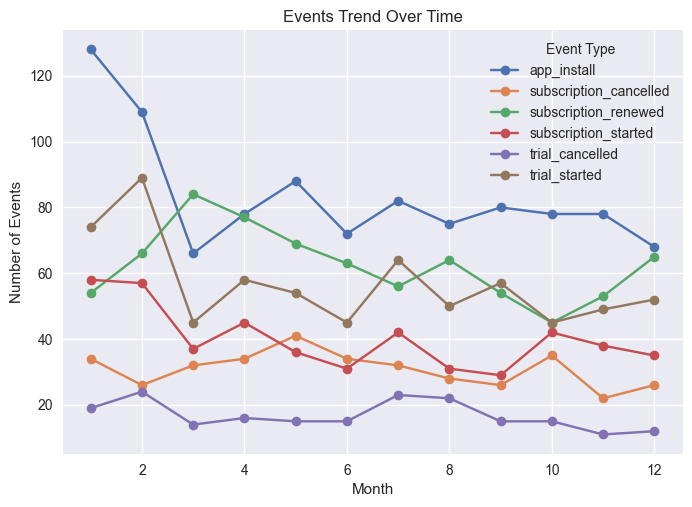

In [315]:
# Graph for event type amount per month
events_df['created_at'] = pd.to_datetime(events_df['created_at'])
events_over_time = events_df.groupby([events_df['created_at'].dt.month, 'event_name']).size().unstack()
events_over_time.plot(marker='o')
plt.title('Events Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.legend(title='Event Type')

Text(70.72222222222221, 0.5, 'Month')

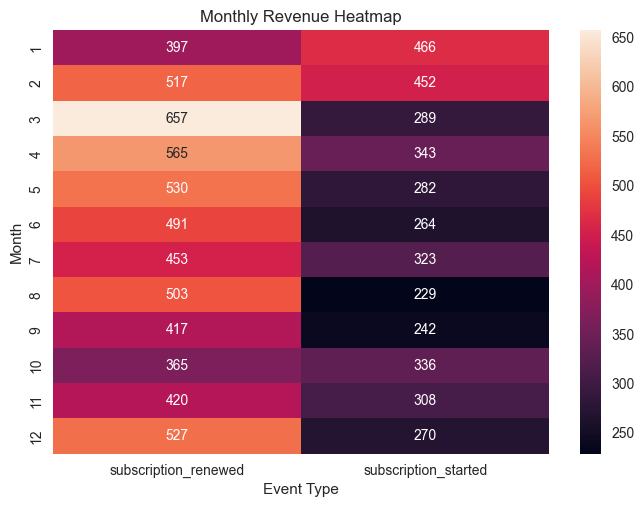

In [316]:
# Graph for revenues by month (Brighter means more revenue)
revenue_events = events_df[events_df['event_name'].isin(['subscription_started', 'subscription_renewed'])]
revenue_pivot = revenue_events.pivot_table(
    index=revenue_events['created_at'].dt.month,
    columns='event_name',
    values='amount_usd',
    aggfunc='sum'
)
sns.heatmap(revenue_pivot, annot=True, fmt='.0f')
plt.title('Monthly Revenue Heatmap')
plt.xlabel('Event Type')
plt.ylabel('Month')

# Step 5 - Solving Tasks

### Task 1

Calculate the total revenue generated from subscriptions for each country.

In [317]:
money_gain_events = events_df[events_df['event_name'].isin(['subscription_started', 'subscription_renewed'])] 

'''
Creating a df from events that have not null value in 'amount_usd'
'''

money_gain_events.head()

,id,created_at,user_id,event_name,amount_usd
5,6,2024-10-20,2,subscription_started,8.99
6,7,2024-11-19,2,subscription_renewed,8.99
7,8,2024-12-19,2,subscription_renewed,8.99
8,9,2025-01-18,2,subscription_renewed,8.99
12,13,2024-10-21,3,subscription_started,4.99


In [318]:
money_gain_data = money_gain_events.merge(users_df[['id', 'country']], left_on='user_id', right_on='id', how='left')

'''
Merging users_df and events_df on 'user_id' to create a table that shows all relevant information.

id_x:'event_id'
id_y:'user_id'

Renaming 'id_x' and dropping 'id_y'.
PS: I'm not going to use it on the result/answer, but I'm goning to do it for this time to make it look more reasonable.
'''

money_gain_data = money_gain_data.rename(columns={'id_x':'event_id'}).drop('id_y', axis=1)
money_gain_data.head()

,event_id,created_at,user_id,event_name,amount_usd,country
0,6,2024-10-20,2,subscription_started,8.99,NL
1,7,2024-11-19,2,subscription_renewed,8.99,NL
2,8,2024-12-19,2,subscription_renewed,8.99,NL
3,9,2025-01-18,2,subscription_renewed,8.99,NL
4,13,2024-10-21,3,subscription_started,4.99,TR


In [319]:
revenue_by_country = (money_gain_data.groupby('country')['amount_usd'] # Grouping by country getting 'amount_usd'
                     .sum() # Summing counts
                     .reset_index() # Series to frame because frame has better readibilty.
                     .rename(columns={'amount_usd': 'total_revenue'})  # Changing 'amount_usd' to 'total_revenue' for better understanding.
                    )

#### Task 1 - A:

In [320]:
revenue_by_country

,country,total_revenue
0,NL,3335.29
1,TR,2275.44
2,US,4035.96


Text(0, 0.5, 'Revenue (USD)')

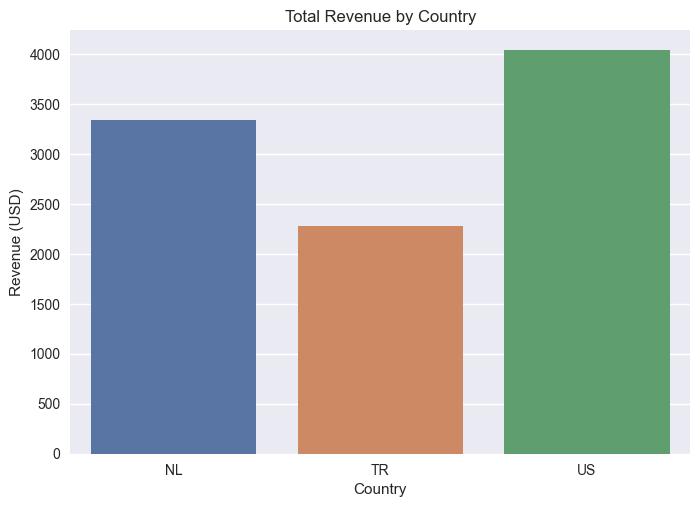

In [321]:
# Graph for revenue/country
sns.barplot(
    data=revenue_by_country,
    x='country',
    y='total_revenue'
)
plt.title('Total Revenue by Country')
plt.xlabel('Country')
plt.ylabel('Revenue (USD)')

### Task 2
Calculate the total number of trials given to users who came from Instagram.

In [322]:
# First of all, finding users coming from isntagram.

instagram_users = users_df[users_df['attribution_source'] == 'instagram']

instagram_users.head()

,id,created_at,attribution_source,country,name
0,1,2024-05-07,instagram,US,Eve Brown
1,2,2024-10-12,instagram,NL,Frank Moore
6,7,2024-10-21,instagram,US,Henry Moore
11,12,2024-01-08,instagram,US,Frank Miller
14,15,2024-07-10,instagram,US,Bob Miller


In [323]:
instagram_trials = events_df[(events_df['event_name'] == 'trial_started') & (events_df['user_id'].isin(instagram_users['id'])) ]

# Filtering events by their type and if they are in instagram_users.

instagram_trials

,id,created_at,user_id,event_name,amount_usd
1,2,2024-05-12,1,trial_started,NaN
4,5,2024-10-13,2,trial_started,NaN
44,45,2024-01-14,12,trial_started,NaN
63,64,2024-07-12,15,trial_started,NaN
66,67,2024-04-28,16,trial_started,NaN
...,...,...,...,...,...
3432,3433,2025-01-17,989,trial_started,NaN
3438,3439,2024-11-26,990,trial_started,NaN
3448,3449,2025-02-09,992,trial_started,NaN
3458,3459,2024-10-04,995,trial_started,NaN


In [324]:
# I can see row count, but return should be an int value so I should get it's len().

total_instagram_trials = len(instagram_trials)

#### Task 2 - A:

In [325]:
total_instagram_trials

210

Text(0, 0.5, 'Number of Trials')

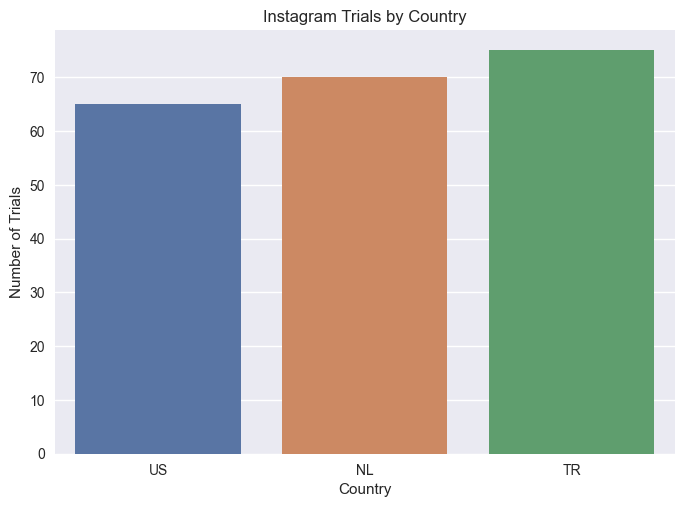

In [326]:
# Graph for trial/country
instagram_trials_by_country = instagram_trials.merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)
sns.countplot(data=instagram_trials_by_country, x='country')
plt.title('Instagram Trials by Country')
plt.xlabel('Country')
plt.ylabel('Number of Trials')

### Task 3
Create a new column named 'acquisition_channel' by categorizing users based on their 'attribution_source':
   - 'Paid': users from instagram or tiktok
   - 'Organic': users from organic sources

In [327]:
# Making every acquistion channel organic and filtering with soruce to modify their values to paid.
updated_users_df = users_df.copy() # Copying originial df to not modify any original value.
updated_users_df['acquisition_channel'] = 'Organic' # Making every acquistion channel organic.

updated_users_df.head()

,id,created_at,attribution_source,country,name,acquisition_channel
0,1,2024-05-07,instagram,US,Eve Brown,Organic
1,2,2024-10-12,instagram,NL,Frank Moore,Organic
2,3,2024-10-15,tiktok,TR,Ivy Anderson,Organic
3,4,2024-08-28,tiktok,TR,Alice Brown,Organic
4,5,2024-04-03,organic,NL,Bob Moore,Organic


In [328]:
# If users source is instagram or tiktok making it paid.
updated_users_df.loc[updated_users_df['attribution_source'].isin(['instagram', 'tiktok']), 'acquisition_channel'] = 'Paid'

updated_users_df.head()

,id,created_at,attribution_source,country,name,acquisition_channel
0,1,2024-05-07,instagram,US,Eve Brown,Paid
1,2,2024-10-12,instagram,NL,Frank Moore,Paid
2,3,2024-10-15,tiktok,TR,Ivy Anderson,Paid
3,4,2024-08-28,tiktok,TR,Alice Brown,Paid
4,5,2024-04-03,organic,NL,Bob Moore,Organic


#### Task 3 - A:

In [329]:
updated_users_df

,id,created_at,attribution_source,country,name,acquisition_channel
0,1,2024-05-07,instagram,US,Eve Brown,Paid
1,2,2024-10-12,instagram,NL,Frank Moore,Paid
2,3,2024-10-15,tiktok,TR,Ivy Anderson,Paid
3,4,2024-08-28,tiktok,TR,Alice Brown,Paid
4,5,2024-04-03,organic,NL,Bob Moore,Organic
...,...,...,...,...,...,...
997,998,2025-02-01,instagram,TR,Bob Davis,Paid
998,999,2024-12-24,organic,NL,Charlie Davis,Organic
999,1000,2025-02-13,organic,NL,Jack Anderson,Organic
1000,1001,2025-02-16,instagram,US,Bruce Wayne,Paid


Text(0, 0.5, 'Number of Users')

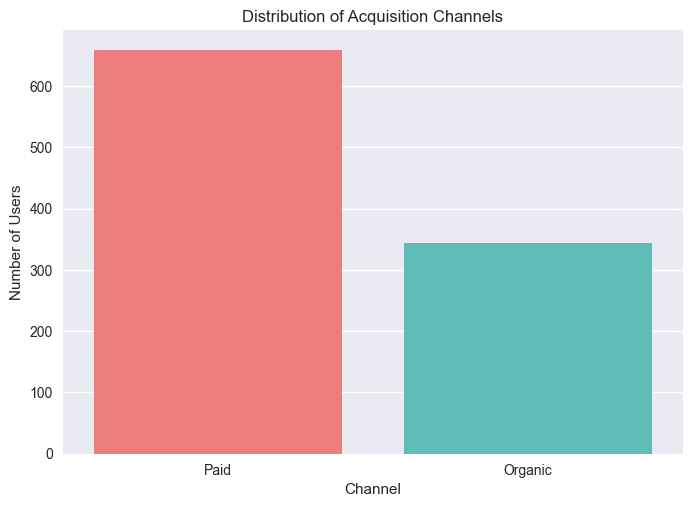

In [330]:
# Graph for acquisition channel distribution over users count.
sns.countplot(
    data=updated_users_df,
    x='acquisition_channel',
    palette=['#ff6b6b', '#4ecdc4']
)
plt.title('Distribution of Acquisition Channels')
plt.xlabel('Channel')
plt.ylabel('Number of Users')

### Task 4
Analyze the trial-to-subscription conversion rate:
   - Calculate the overall conversion rate
   - Break down the conversion rate by attribution_source

#### Task 4-1

In [331]:
# Finding how many 'trails_started' and 'subscriptions_started'.

total_trials = events_df[events_df['event_name'] == 'trial_started'].shape[0]
total_conversions = events_df[events_df['event_name'] == 'subscription_started'].shape[0]

In [332]:
# Calculating conversion rate.
# Adding '%' to end of conversion rate.

overall_conversion_rate = str(round((total_conversions / total_trials * 100), 2))+'%'

##### Task 4-1 - A:

In [333]:
overall_conversion_rate

'70.53%'

Text(0.5, 1.0, 'Overall Trial to Subscription\nConversion Rate')

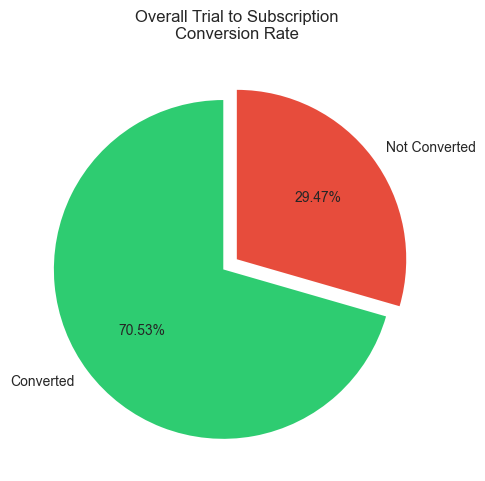

In [334]:
# Graph for converion rate
values = [total_conversions, total_trials - total_conversions]
colors = ['#2ecc71', '#e74c3c']

plt.pie(values, 
        labels=['Converted','Not Converted'], 
        autopct='%1.2f%%', 
        colors=colors,
        startangle=90,
        explode=(0.1, 0))
plt.title('Overall Trial to Subscription\nConversion Rate')

#### Task 4-2

In [335]:
# Merging 'attribiton_source' with event_df.

events_with_source = events_df.merge(
    users_df[['id', 'attribution_source']], 
    left_on='user_id', 
    right_on='id'
)

events_with_source

,id_x,created_at,user_id,event_name,amount_usd,id_y,attribution_source
0,1,2024-05-07,1,app_install,NaN,1,instagram
1,2,2024-05-12,1,trial_started,NaN,1,instagram
2,3,2024-05-24,1,trial_cancelled,NaN,1,instagram
3,4,2024-10-12,2,app_install,NaN,2,instagram
4,5,2024-10-13,2,trial_started,NaN,2,instagram
...,...,...,...,...,...,...,...
3481,3482,2025-02-25,1000,trial_cancelled,NaN,1000,organic
3482,3483,2025-02-25,1001,app_install,NaN,1001,instagram
3483,3484,2025-02-25,1001,trial_started,NaN,1001,instagram
3484,3485,2025-02-25,1001,subscription_started,9.99,1001,instagram


In [336]:
# Getting count of 'trial_started' and 'subscription_started' by source
conversion_df = pd.DataFrame({
    'trials': events_with_source[events_with_source['event_name'] == 'trial_started']
                .groupby('attribution_source')
                .size(),
    'subscriptions': events_with_source[events_with_source['event_name'] == 'subscription_started']
                .groupby('attribution_source')
                .size()
})

conversion_df

,trials,subscriptions
attribution_source,,
instagram,210,149
organic,236,169
tiktok,236,163


In [337]:
# Calculating conversion_rate with 'subscription_started' / 'trials_started'.
conversion_df['conversion_rate'] = round((conversion_df['subscriptions'] / conversion_df['trials'] * 100), 2)

# Adding '%' to the end.
conversion_df['conversion_rate'] = conversion_df['conversion_rate'].astype(str) + '%' 

##### Task 4-2 - A:

In [338]:
conversion_df

,trials,subscriptions,conversion_rate
attribution_source,,,
instagram,210,149,70.95%
organic,236,169,71.61%
tiktok,236,163,69.07%


Text(0, 0.5, 'Conversion Rate (%)')

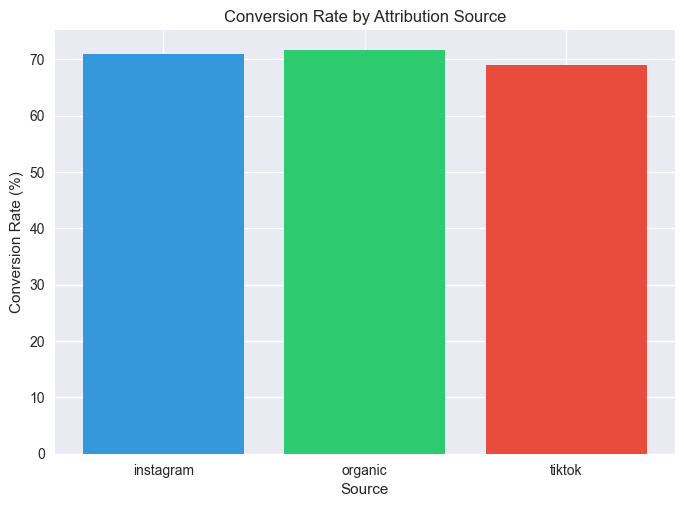

In [339]:
# Graph for conversion rate by source
conversion_rates = conversion_df['conversion_rate'].str.rstrip('%').astype(float)
bars = plt.bar(conversion_df.index, conversion_rates, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Conversion Rate by Attribution Source')
plt.xlabel('Source')
plt.ylabel('Conversion Rate (%)')


#### Task 4-Optional

In this part we will create a df and graph for percentaging subscription to source

In [340]:
# Finding how many subscriptions we get, yes I have already found it, but this is an optional part, so I will find again.
subs_df = pd.DataFrame({
    'subscriptions' :events_with_source[events_with_source['event_name'] == 'subscription_started']
                        .groupby('attribution_source')
                        .size()})

subs_df

,subscriptions
attribution_source,
instagram,149
organic,169
tiktok,163


In [341]:
# Total subscription value
total_subs = subs_df.sum()
total_subs

subscriptions    481
dtype: int64

In [342]:
# Finding subscription percentage by soruce.
subscription_percentage = round((subs_df / total_subs * 100), 2)
subscription_percentage = subscription_percentage['subscriptions'].astype(str) + '%' # Adding '%' to end

subscription_percentage

attribution_source
instagram    30.98%
organic      35.14%
tiktok       33.89%
Name: subscriptions, dtype: object

In [343]:
# Series to Frame
subscription_percentage_df = pd.DataFrame(subscription_percentage)

# Renaming subscriptions to percantage.
subscription_percentage_df = subscription_percentage_df.rename(columns={'subscriptions':'percentage'})

##### Task 4-Opsionel - A:

In [344]:
subscription_percentage_df # Total value round to %100.01 because of rounding error but it's not a significant error so lets continue with other task.

,percentage
attribution_source,
instagram,30.98%
organic,35.14%
tiktok,33.89%


Text(0.5, 1.0, 'Subscription Distribution by Source')

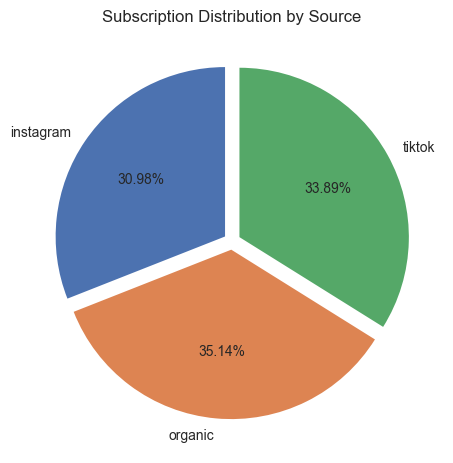

In [345]:
# Graph for distributon by source.

subscription_percentages = subscription_percentage_df['percentage'].str.rstrip('%').astype(float)
plt.pie(subscription_percentages, 
        labels=subscription_percentage_df.index,
        autopct='%1.2f%%',
        startangle=90,
        explode=[0.05] * len(subscription_percentage_df))
plt.title('Subscription Distribution by Source')

### Task 5

Calculate the median subscription duration (in months) for each country

In [346]:
# Creating a new table including events with name 'subscription_started' and 'subscription_renewed'
subscription_events = events_df[
    events_df['event_name'].isin(['subscription_started', 'subscription_renewed'])
].merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)

subscription_events

,id_x,created_at,user_id,event_name,amount_usd,id_y,country
0,6,2024-10-20,2,subscription_started,8.99,2,NL
1,7,2024-11-19,2,subscription_renewed,8.99,2,NL
2,8,2024-12-19,2,subscription_renewed,8.99,2,NL
3,9,2025-01-18,2,subscription_renewed,8.99,2,NL
4,13,2024-10-21,3,subscription_started,4.99,3,TR
...,...,...,...,...,...,...,...
1226,3468,2025-04-07,996,subscription_renewed,4.99,996,TR
1227,3476,2025-01-03,999,subscription_started,8.99,999,NL
1228,3477,2025-02-02,999,subscription_renewed,8.99,999,NL
1229,3478,2025-03-04,999,subscription_renewed,8.99,999,NL


In [347]:
# As we have all the information, we can calculate values.
subscription_duration = (subscription_events
    .groupby(['user_id', 'country'])
    .size()  # events per user.
    .reset_index(name='months') # Renaming column from 0 to months for better understanding.
)

subscription_duration

,user_id,country,months
0,2,NL,4
1,3,TR,4
2,8,TR,2
3,9,US,2
4,10,US,2
...,...,...,...
476,992,US,5
477,995,US,3
478,996,TR,3
479,999,NL,3


In [348]:
# I grouped countries and get their months median.
median_duration = subscription_duration.groupby('country')['months'].median()


median_duration_df = pd.DataFrame(median_duration) # Series to Frame

#### Task 5 - A:

In [349]:
median_duration_df

,months
country,
NL,2.0
TR,3.0
US,2.0


Text(0, 0.5, 'Duration (Months)')

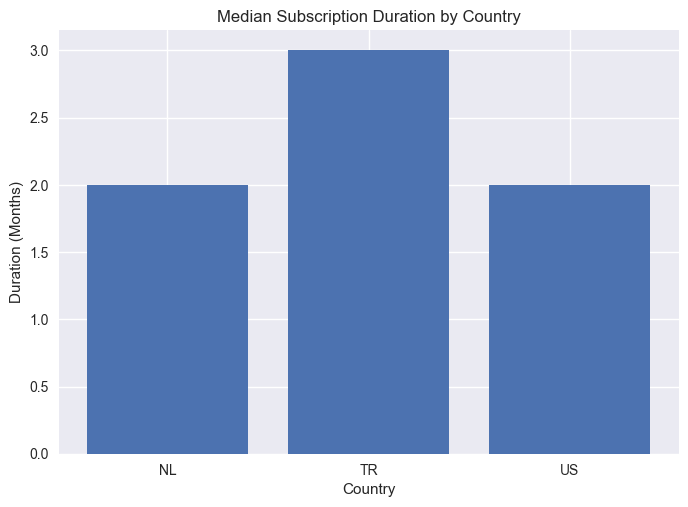

In [350]:
# Graph for duration/country
bars = plt.bar(median_duration_df.index, 
               median_duration_df['months'])
plt.title('Median Subscription Duration by Country')
plt.xlabel('Country')
plt.ylabel('Duration (Months)')

### Task 6
Calculate the Average Lifetime Value (LTV) by country

In [351]:
# Again, merging subs related columns with user_df's id and country.

subscription_revenue = events_df[
    events_df['event_name'].isin(['subscription_started', 'subscription_renewed'])
].merge(
    users_df[['id', 'country']], 
    left_on='user_id', 
    right_on='id'
)

subscription_revenue.head()

,id_x,created_at,user_id,event_name,amount_usd,id_y,country
0,6,2024-10-20,2,subscription_started,8.99,2,NL
1,7,2024-11-19,2,subscription_renewed,8.99,2,NL
2,8,2024-12-19,2,subscription_renewed,8.99,2,NL
3,9,2025-01-18,2,subscription_renewed,8.99,2,NL
4,13,2024-10-21,3,subscription_started,4.99,3,TR


In [352]:
# Calculating users total spendings.

user_ltv = (subscription_revenue
    .groupby(['user_id', 'country'])['amount_usd']
    .sum()
    .reset_index()
)

user_ltv.head()

,user_id,country,amount_usd
0,2,NL,35.96
1,3,TR,19.96
2,8,TR,9.98
3,9,US,19.98
4,10,US,19.98


In [353]:
# I have every users' total revenue and country, I'm getting average value by calculating it by their groupings, countries.

avg_ltv_by_country = pd.DataFrame(user_ltv
    .groupby('country')['amount_usd']
    .mean()
    .round(2)
)

avg_ltv_by_country['amount_usd'] = '$'+avg_ltv_by_country['amount_usd'].astype(str)
avg_ltv_by_country = avg_ltv_by_country.rename(columns={'amount_usd':'average_revenue'})


#### Task 6 - A:

In [354]:
avg_ltv_by_country


,average_revenue
country,
NL,$22.38
TR,$13.31
US,$25.07


C:\Users\batuh\AppData\Local\Temp\ipykernel_6588\2589381735.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ltv_values = avg_ltv_by_country['average_revenue'].str.replace('$', '').astype(float) # Str to float for graph


Text(0, 0.5, 'Average LTV (USD)')

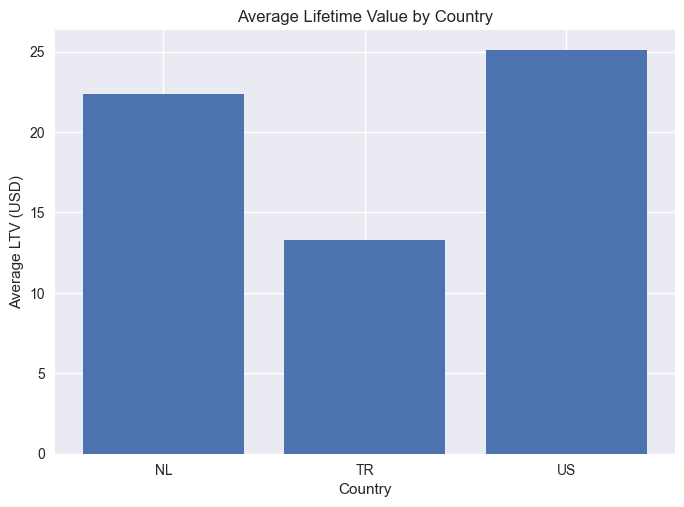

In [355]:
ltv_values = avg_ltv_by_country['average_revenue'].str.replace('$', '').astype(float) # Str to float for graph

# Graph for avgltv by country
bars = plt.bar(avg_ltv_by_country.index, 
               ltv_values)
plt.title('Average Lifetime Value by Country')
plt.xlabel('Country')
plt.ylabel('Average LTV (USD)')

### Task 7
Predict the churn probability for user #1002 (Clark Kent)

Use any relevant features from the dataset
Explain your model selection and feature engineering process
Provide confidence intervals if applicable

In [356]:
# Importing libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

In [357]:
# Making 'amount_usd' nulls to 0 for preventing error while modelling.

events_df['amount_usd'] = events_df['amount_usd'].fillna(0)

In [358]:
# Creating new feature and onehot encoding categorical values.

def create_features(events_df, users_df):
    user_features = []
    
    for user_id in users_df['id']:
        user_events = events_df[events_df['user_id'] == user_id] # User's events table features
        user_info = users_df[users_df['id'] == user_id].iloc[0] # User's users table features
        
        features = {
            'user_id': user_id, # User_id for that user
            'subscription_count': user_events[user_events['event_name'].isin(['subscription_started', 'subscription_renewed'])].shape[0], # How many times a user subscribes
            'total_revenue': user_events['amount_usd'].sum(), # How much payment done by user
            'had_trial': any(user_events['event_name'] == 'trial_started'), # Have user had any trial
            'trial_converted': any(user_events['event_name'] == 'trial_started') and  
                             any(user_events['event_name'] == 'subscription_started'), # Checking if user had 'trial_started' and 'subscriptiom_started'
            'is_organic': user_info['attribution_source'] == 'organic', # Is user's attr_src organic
            'is_instagram': user_info['attribution_source'] == 'instagram' ,# Is user's attr_src instagram
            'is_tiktok': user_info['attribution_source'] == 'tiktok', # Is user's attr_src tiktok
            'country_US': user_info['country'] == 'US', # Is user's country US
            'country_TR': user_info['country'] == 'TR', # Is user's country TR
            'country_NL': user_info['country'] == 'NL', # Is user's country NL
            'churned': any(user_events['event_name'] == 'subscription_cancelled') # If user has a subs_cancel that user is churned
        }
        user_features.append(features)
    
    return pd.DataFrame(user_features)

In [359]:
features_df = create_features(events_df, users_df) # Making df with function above.

In [360]:
features_df

,user_id,subscription_count,total_revenue,had_trial,trial_converted,is_organic,is_instagram,is_tiktok,country_US,country_TR,country_NL,churned
0,1,0,0.00,True,False,False,True,False,True,False,False,False
1,2,4,35.96,True,True,False,True,False,False,False,True,True
2,3,4,19.96,True,True,False,False,True,False,True,False,True
3,4,0,0.00,True,False,False,False,True,False,True,False,False
4,5,0,0.00,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
997,998,0,0.00,False,False,False,True,False,False,True,False,False
998,999,3,26.97,True,True,True,False,False,False,False,True,True
999,1000,0,0.00,True,False,True,False,False,False,False,True,False
1000,1001,1,9.99,True,True,False,True,False,True,False,False,False


In [361]:
# Prediction target is 'churned' so we split df for training.
X = features_df.drop(['user_id', 'churned'], axis=1) # User_id is irrelevant and the target is 'churned', so we drop those values.
y = features_df['churned'] # The target value

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Standart train test spliting

In [363]:
# I scaled the features making them scaled because some features like total_rev will have higher impact on our target becasue most of our features are 0/1 -False/True.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [364]:
'''
I chose LogisticRegression because 'churned' value is True or False, it's a binary decision.
I want to take a look at the feature importance for business strategies to determine in real life approaches.
'''

model = LogisticRegression(random_state=42) 
model.fit(X_train_scaled, y_train)



LogisticRegression(random_state=42)

In [365]:
user_1002_features = features_df[features_df['user_id'] == 1002].drop(['user_id', 'churned'], axis=1) # Getting features for user_id 1002
user_1002_scaled = scaler.transform(user_1002_features) # Scaling values
churn_probability = model.predict_proba(user_1002_scaled)[0][1] # Getting churn probability for user 1002

In [366]:
# I have already found the probabilty but lest analayze more
feature_impact = pd.DataFrame({
    'feature': X.columns, # Features in df
    'impact': model.coef_[0] # Coefficient for its impact value, it can be positive or negative
})

feature_impact = feature_impact.sort_values('impact', ascending=False) # Sorting impact values by their values.

In [367]:
# Making its importance to churn, it's almost the same df but with absolute value on impact -> importance column.

feature_importance = pd.DataFrame({
    'feature': feature_impact['feature'],
    'importance': feature_impact['impact'].abs()
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

#### Task 7 - A:


In [368]:
churn_probability

0.0005141024656188886

In [369]:
feature_impact

,feature,impact
0,subscription_count,4.540945
1,total_revenue,3.838298
8,country_TR,0.638214
3,trial_converted,0.230802
2,had_trial,0.134874
5,is_instagram,0.064670
6,is_tiktok,-0.020954
4,is_organic,-0.041856
9,country_NL,-0.251924
7,country_US,-0.404605


In [370]:
'''
Positive values are have positive impact to churn, so if users subs_count is increasing, they are more likely to churn. In real life, it may not be like this but with this amount of
data I found this correlation. But there are meaningful insights too, users from TR is more likely to chrun than other countries.
'''
print(f'Amount of feature: {len(feature_impact.feature)}')
print(f'Highest impact feature: {feature_impact.iloc[0].feature}')
print(f'Impact: {round(feature_impact.iloc[0].impact,2)}')
print(f'Lowest impact feature: {feature_impact.iloc[-1].feature}')
print(f'Impact: {round(feature_impact.iloc[-1].impact,2)}')



Amount of feature: 10
Highest impact feature: subscription_count
Impact: 4.54
Lowest impact feature: country_US
Impact: -0.4


([<matplotlib.axis.YTick at 0x1f50e1a2dd0>,
 [Text(0, 0, 'country_US'),
  Text(0, 1, 'country_NL'),
  Text(0, 2, 'is_organic'),
  Text(0, 3, 'is_tiktok'),
  Text(0, 4, 'is_instagram'),
  Text(0, 5, 'had_trial'),
  Text(0, 6, 'trial_converted'),
  Text(0, 7, 'country_TR'),
  Text(0, 8, 'total_revenue'),
  Text(0, 9, 'subscription_count')])

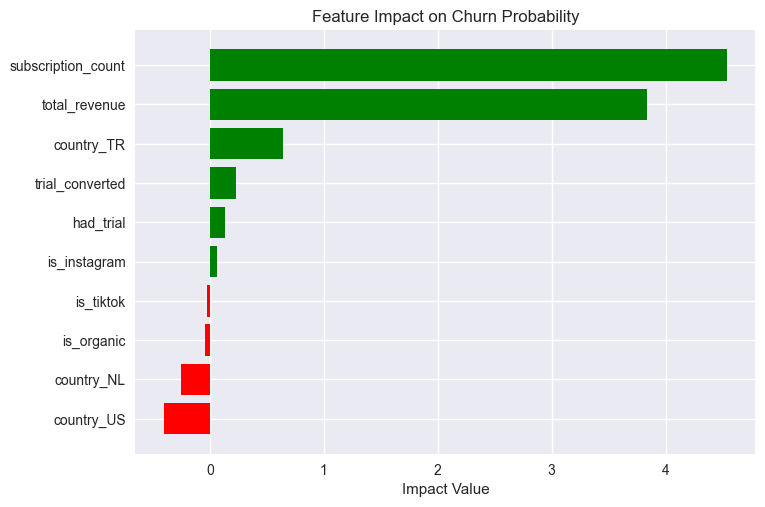

In [371]:
feature_impact_sorted = feature_impact.sort_values('impact',ascending=True) # Making first negative impact after positive impact to insert to table

# Graph for visualizing our impact
bars = plt.barh(range(len(feature_impact_sorted)), 
                feature_impact_sorted['impact'],
                color=['green' if x >= 0 else 'red' for x in feature_impact_sorted['impact']])
plt.title('Feature Impact on Churn Probability')
plt.xlabel('Impact Value')
plt.yticks(range(len(feature_impact_sorted)), feature_impact_sorted['feature'])

In [372]:
feature_importance

,feature,importance
0,subscription_count,4.540945
1,total_revenue,3.838298
8,country_TR,0.638214
7,country_US,0.404605
9,country_NL,0.251924
3,trial_converted,0.230802
2,had_trial,0.134874
5,is_instagram,0.064670
4,is_organic,0.041856
6,is_tiktok,0.020954


In [373]:
'''
Importance of values, basicly almost the same df but with absoulte values to determine which feature has higher impact,
original value may be negative and can affect more than other positive effects, so it may make more sense to make negatives less unattractive than making positives more attractive.
'''

print(f'Amount of feature: {len(feature_importance.feature)}')
print(f'Most important feature: {feature_importance.iloc[0].feature}')
print(f'Importance: {round(feature_importance.iloc[0].importance,2)}')
print(f'Least improtant feature: {feature_importance.iloc[-1].feature}')
print(f'Importnace: {round(feature_importance.iloc[-1].importance,2)}')

Amount of feature: 10
Most important feature: subscription_count
Importance: 4.54
Least improtant feature: is_tiktok
Importnace: 0.02


Text(0.5, 0, 'Absolute Importance')

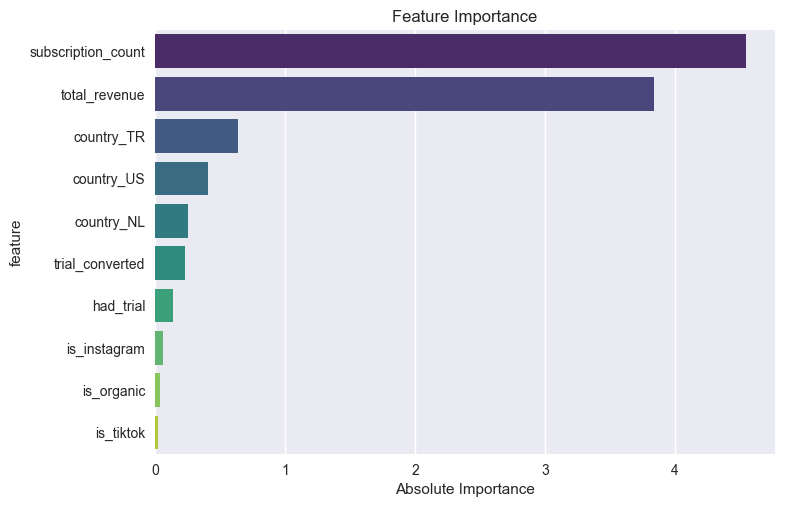

In [374]:
# Graph for visualizing our importance
sns.barplot(data=feature_importance, 
            y='feature',
            x='importance',
            palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Absolute Importance')

### Task 8
Predict the potential Lifetime Value (pLTV) for user #1001 (Bruce Wayne)

Explain your methodology and assumptions

In [375]:
# Creating a function for prediction

def predict_plv(user_id, churn_model, scaler): # Users_id, our task-7 churn proba model, standart scaler

    user_events = events_df[events_df['user_id'] == user_id].sort_values('created_at') # Events that users' action by timestamp order
    
    
    monthly_payment = user_events[
        user_events['event_name'].isin(['subscription_started', 'subscription_renewed'])
    ]['amount_usd'].iloc[-1] if len(user_events) > 0 else 0 # Last monthly payment
    
    user_features = create_features(events_df, users_df) # Function I created at task-7
    user_features = user_features[user_features['user_id'] == user_id].drop(['user_id', 'churned'], axis=1) # Dropping columns for prediction
    
    user_features_scaled = scaler.transform(user_features) # Scaling for one that we wanted to test
    churn_probability = churn_model.predict_proba(user_features_scaled)[0][1] # Getting probability of churn
    
    
    pltv = (monthly_payment / churn_probability).round(2) # pLTV = monthly payment / churn_probability 
    
    return {
        'user_id': user_id,
        'monthly_payment': monthly_payment,
        'churn_probability': churn_probability,
        'pltv': pltv
    }

In [376]:
prediction = predict_plv(1001, model, scaler) # Getting prediction

In [377]:
# Confidence interval calculation with bootstrap because it's not dependant on distirbution.
n_iterations = 10 # How many different sample will generate, normally it will be like 1000, but for the sake of our time I make it 10, making it 1000 will make it more stable.
pltv_predictions = []

for _ in range(n_iterations):
    indices = np.random.randint(0, len(X_train), len(X_train)) # Random selection for training.
    sample_X = X_train_scaled[indices] 
    sample_y = y_train.iloc[indices]
    
    sample_model = LogisticRegression(random_state=42) # I use logistic regression to get churn prob for this dataset.
    sample_model.fit(sample_X, sample_y) # Model fitting
    
    user_features = create_features(events_df, users_df) # Function I used in task-7 for churn prob
    user_features = user_features[user_features['user_id'] == 1001].drop(['user_id', 'churned'], axis=1) # Getting churn prob of 1001 id
    user_features_scaled = scaler.transform(user_features)
    
    churn_prob = sample_model.predict_proba(user_features_scaled)[0][1] # Churn prob
    pltv = (prediction['monthly_payment'] / churn_prob).round(2) # Monthly payment / churn prob
    pltv_predictions.append(pltv) # Storing them in list

confidence_interval = np.percentile(pltv_predictions, [2.5, 97.5]) # Finding minimum and maximum pltv with 95% confidence.

#### Task 8 - A:

In [378]:
print(f"User ID: {prediction['user_id']}")
print(f"Current Monthly Payment: ${prediction['monthly_payment']}")
print(f"Churn Probability: {prediction['churn_probability']:.2%}")
print(f"Lifetime Value: ${prediction['pltv']}")
print(f"pLTV Range: ${confidence_interval[0]:.2f} - ${confidence_interval[1]:.2f}")

User ID: 1001
Current Monthly Payment: $9.99
Churn Probability: 6.23%
Lifetime Value: $160.39
pLTV Range: $127.16 - $192.22


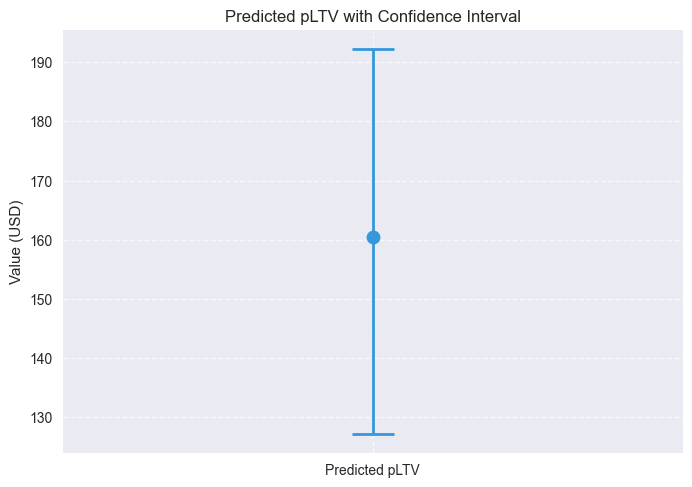

In [379]:
plt.errorbar(x=['Predicted pLTV'], 
             y=[prediction['pltv']], 
             yerr=[[prediction['pltv'] - confidence_interval[0]], 
                   [confidence_interval[1] - prediction['pltv']]],
             fmt='o', 
             color='#3498db',
             capsize=15,
             capthick=2,
             elinewidth=2,
             markersize=10)
plt.title('Predicted pLTV with Confidence Interval')
plt.ylabel('Value (USD)')
plt.grid(True, linestyle='--', alpha=0.7)